# Classification: Data Modeling

In [1]:
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from os.path import exists

from scipy.stats import uniform

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [2]:
target = 'tweets'

# The first line for upsampled data, the second for the original data
supervised_up_target_path = f'../dataset/processed/supervised_{target}_upsampled.csv'
supervised_target_path = f'../dataset/processed/supervised_{target}.csv'

model_path = '../dataset/model/sental_model.pkl'
model_best_params_path = '../dataset/model/svm_best_params.pkl'
vectorizer_path = '../dataset/model/sental_vectorizer.pkl'

In [3]:
# df = pd.read_csv(supervised_target_path, delimiter=';')
df = pd.read_csv(supervised_up_target_path, delimiter=';')
df.dropna(inplace=True)

df.head()

,content,tokens,tokens_ready,text,polarity,sentiment
0,@hnurwahid Ngaku masih subsidi tapi ada swasta...,"['mengaku', 'subsidi', 'swasta', 'jual', 'mura...","['subsidi', 'swasta', 'jual', 'murah', 'subsid...",subsidi swasta jual murah subsidi pimpin tukan...,6,1
1,@Tan_Mar3M Kalau Vivo bisaberani bertahan deng...,"['berani', 'bertahan', 'harga', 'nasib']","['berani', 'tahan', 'harga', 'nasib']",berani tahan harga nasib,4,1
2,Menteri BUMN Erick Thohir menegaskan persiapan...,"['menteri', 'bumn', 'erick', 'thohir', 'persia...","['menteri', 'bumn', 'erick', 'thohir', 'indone...",menteri bumn erick thohir indonesia transisi e...,2,1
3,"Itu kata orang pertamina si wkwkwk, dan hampir...","['orang', 'wkwkwk', 'uji', 'sirkulasi', 'franc...","['orang', 'wkwkwk', 'uji', 'sirkulasi', 'franc...",orang wkwkwk uji sirkulasi franchise pertashop...,4,1
4,@eradotid Ya lagian vivo kan bukan punya pemer...,"['pemerintah', 'sumber', 'minyaknya', 'beda', ...","['perintah', 'sumber', 'minyak', 'beda', 'supl...",perintah sumber minyak beda suplier istilah ur...,1,1


## Section 1: Term weighting with TF-IDF & Data Splitting

In [4]:
def term_weighting_tfidf(X_train, X_test):
	vectorizer = TfidfVectorizer(use_idf=True)

	X_train_tfidf = vectorizer.fit_transform(X_train)
	X_test_tfidf = vectorizer.transform(X_test)
	return X_train_tfidf, X_test_tfidf, vectorizer

def save_vectorizer(model_vectorizer):
  with open(vectorizer_path, 'wb') as f:
    pickle.dump(model_vectorizer, f)

In [5]:
def split_data(test_size=0.2):
		X = df['text']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687)

def split_stratified_data(test_size=0.2):
		X = df['text']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687, stratify=y)

## Section 2: Classification with SVM

In [6]:
def save_svm_best_param(best_params):
  with open(model_best_params_path, "wb") as f:
    pickle.dump(best_params, f)

def save_model(model):
  with open(model_path, 'wb') as f:
    pickle.dump(model, f)

def random_best_search_param(X_train_tfidf, y_train):
  param_grid = {'C': uniform(loc=0, scale=4),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': uniform(loc=0, scale=0.1)}
  model = svm.SVC()
  grid_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, random_state=0, verbose=1)
  grid_search.fit(X_train_tfidf, y_train)

  save_svm_best_param(grid_search.best_params_)

  print("Best parameters: ", grid_search.best_params_)
  print("Best score: ", grid_search.best_score_)
  
  return grid_search.best_params_

def load_svm_best_param():
	try:
		with open(model_best_params_path, 'rb') as f:
			return pickle.load(f)
	except FileNotFoundError:
		return None

def load_svm_model():
    model = None

    if exists(model_path):
      with open(model_path, 'rb') as f:
        model = pickle.load(f)
    else:
      best_params = load_svm_best_param()
      if best_params is None:
        best_params = random_best_search_param()
        print("Loaded best parameters from grid search")
      else:
        print("Use parameters: ", best_params)
        print("Loaded best parameters from file")
      
      model = svm.SVC(**best_params)

    return model

def model_predict(model, y, y_pred):
	acc = accuracy_score(y, y_pred)
	precision = precision_score(y, y_pred, average='binary')
	recall = recall_score(y, y_pred, average='binary')
	f1 = f1_score(y, y_pred, average='binary')
	matrix = confusion_matrix(y, y_pred)

	print("Accuracy:", acc)
	print("Precision:", precision)
	print("Recall:", recall)
	print("F1-Score:", f1)
	print('\n Report : ') 
	print(classification_report(y, y_pred))
	print('Confusion Matrix : ')

	f, ax = plt.subplots(figsize=(8,5))
	sns.heatmap(matrix, annot=True, fmt=".0f", ax=ax)
	plt.xlabel("Predicted")
	plt.ylabel("Actual")
	plt.show()

## Section 3: Experiments

### Section 3.1: SVM with TF-IDF (Non-Stratified Data)

In [7]:
X_train, X_test, y_train, y_test = split_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

svm_model = load_svm_model()
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Use parameters:  {'C': 3.8286206358121855, 'gamma': 0.014035078041264516, 'kernel': 'linear'}
Loaded best parameters from file
Model score:  0.9324181626187962


#### Section 3.1.1: Evaluation

Accuracy: 0.9948514851485148
Precision: 0.997618417570786
Recall: 0.9921052631578947
F1-Score: 0.9948542024013722

 Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3775
           1       1.00      0.99      0.99      3800

    accuracy                           0.99      7575
   macro avg       0.99      0.99      0.99      7575
weighted avg       0.99      0.99      0.99      7575

Confusion Matrix : 


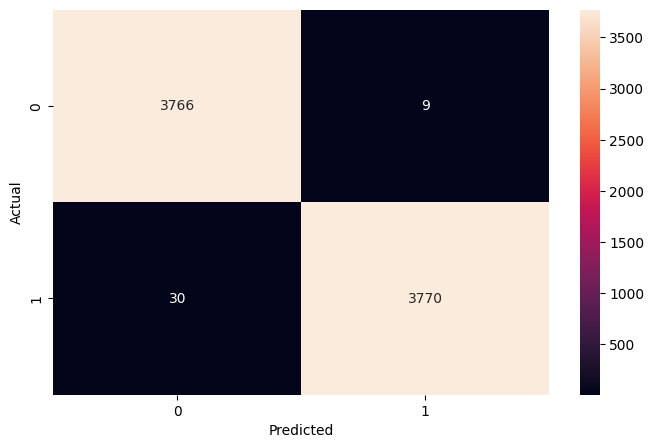

Accuracy: 0.9324181626187962
Precision: 0.9538288288288288
Recall: 0.9068522483940042
F1-Score: 0.9297475301866082

 Report : 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       960
           1       0.95      0.91      0.93       934

    accuracy                           0.93      1894
   macro avg       0.93      0.93      0.93      1894
weighted avg       0.93      0.93      0.93      1894

Confusion Matrix : 


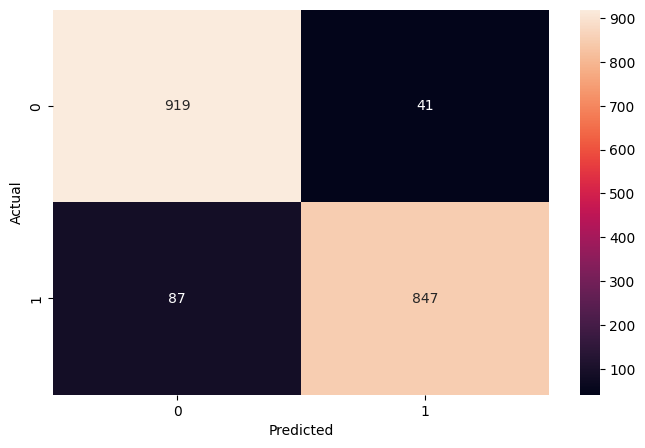

In [8]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_train, y_pred_train)
model_predict(svm_model, y_test, y_pred_test)

### Section 3.2: SVM with TF-IDF (Stratified Data)

In [9]:
X_train, X_test, y_train, y_test = split_stratified_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

svm_model = load_svm_model()
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Use parameters:  {'C': 3.8286206358121855, 'gamma': 0.014035078041264516, 'kernel': 'linear'}
Loaded best parameters from file
Model score:  0.9308342133051742


#### Section 3.2.1: Evaluation

Accuracy: 0.9936633663366337
Precision: 0.9962835147332094
Recall: 0.9910219170847636
F1-Score: 0.9936457505957108

 Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3788
           1       1.00      0.99      0.99      3787

    accuracy                           0.99      7575
   macro avg       0.99      0.99      0.99      7575
weighted avg       0.99      0.99      0.99      7575

Confusion Matrix : 


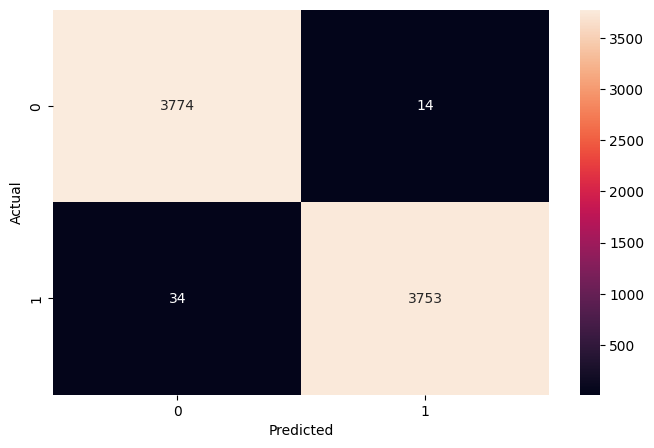

Accuracy: 0.9308342133051742
Precision: 0.9553571428571429
Recall: 0.9039070749736009
F1-Score: 0.9289202387411829

 Report : 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       947
           1       0.96      0.90      0.93       947

    accuracy                           0.93      1894
   macro avg       0.93      0.93      0.93      1894
weighted avg       0.93      0.93      0.93      1894

Confusion Matrix : 


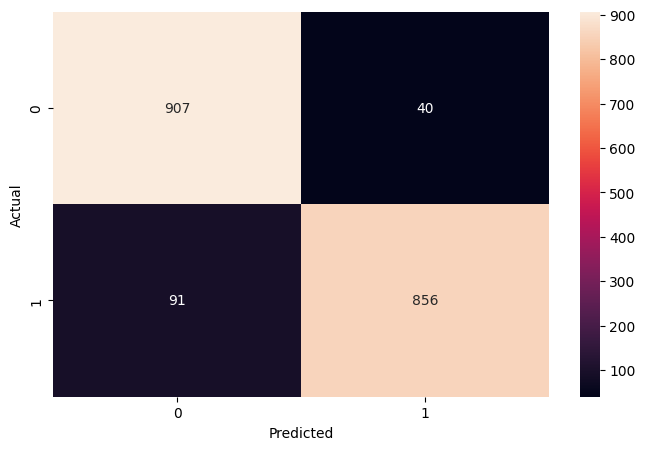

In [10]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_train, y_pred_train)
model_predict(svm_model, y_test, y_pred_test)

## Section 4: Test & Conclusion

In [11]:
%run "../shared.py"

In [12]:
# Results from prediction sentiment on data test

texts = df['text']
text_train, text_test = train_test_split(texts, test_size=0.2, random_state=687)

result_test = pd.DataFrame(data=zip(text_test, y_pred_test), columns=['text', 'polarity'])

polarity_decode = {0 : 'Negative', 1 : 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)

pd.set_option('max_colwidth', 300)
result_test.sample(10)

,text,polarity
1771,kyny ajar,Positive
1108,melotot bilang merem untung melek petronas ahok,Negative
1833,info salah audit cek tombol bro dispenser cek segel tera takar pas tera acak speed sesuai standar bbm bejana ukur,Negative
1274,kena prank,Positive
1545,susah sarangx tikus das,Negative
1412,cabang indonesia laba kompetitor kota serius,Negative
1768,sebentar malam big match petronas,Negative
420,perintah provinsi papua barat upaya ajak antri isi bbm spbu dampak distribusi logistik wilayah provinsi papuaamandamai papuaaman,Positive
739,breaking news demo,Positive
1407,cerdas maju negri,Positive


In [13]:
sample_text = 'Kami Mendukung Keputusan PemeRintah untUk menAIkkan HARga BBM'
sample_text = preprocess_text(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Normalization list: 1034
Indonesian stopwords: 758
English stopwords: 179
Custom stopwords: 2
Total stopwords: 939
Sampel text: dukung putus perintah naik harga bbm
Sentiment: Positive


In [14]:
sample_text = 'saya benci dengan pemerintah'
sample_text = preprocess_text(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Normalization list: 1034
Indonesian stopwords: 758
English stopwords: 179
Custom stopwords: 2
Total stopwords: 939
Sampel text: benci perintah
Sentiment: Negative


In [15]:
save_model(svm_model)
save_vectorizer(vectorizer)